In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
 
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer.primitives import EstimatorV2 as Estimator

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

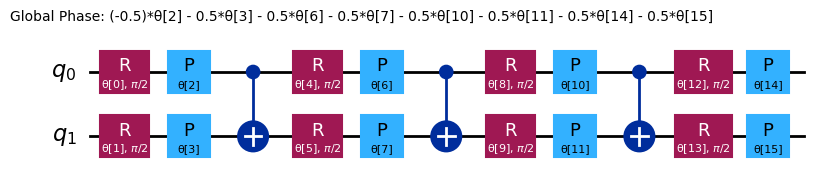

In [3]:
ansatz = efficient_su2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [4]:
num_params = ansatz.num_parameters
num_params

16

In [5]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [6]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
 
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(
        f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]"
    )
 
    return energy

In [7]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.88668443, 5.68796633, 5.21800133, 1.50870127, 5.32252809,
       3.01345301, 2.08113127, 5.84609181, 1.75791383, 6.16249339,
       0.25143549, 0.16657998, 4.49395773, 5.76377238, 6.22229891,
       2.42522444])

In [8]:
estimator = Estimator()
estimator.options.run_options = {
    "shots": 10_000
}

In [9]:
result = estimator.run(pubs=[(ansatz, [hamiltonian], [x0])]).result()

In [14]:
result[0].data.evs[0]

np.float64(0.11359611551439086)

In [31]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA"
)

Iters. done: 1 [Current cost: 0.2089730485596065]
Iters. done: 2 [Current cost: 0.007807262115177859]
Iters. done: 3 [Current cost: -0.1500536013799645]
Iters. done: 4 [Current cost: -0.1867465196568625]
Iters. done: 5 [Current cost: -0.11777664263359157]
Iters. done: 6 [Current cost: 0.03959180938065174]
Iters. done: 7 [Current cost: -0.37562489627723583]
Iters. done: 8 [Current cost: -0.38514215996296897]
Iters. done: 9 [Current cost: -0.12627835621856573]
Iters. done: 10 [Current cost: -0.3172579256446618]
Iters. done: 11 [Current cost: -0.4060134068259464]
Iters. done: 12 [Current cost: -0.45011094936029883]
Iters. done: 13 [Current cost: -0.20281046065330974]
Iters. done: 14 [Current cost: -0.3088910437665985]
Iters. done: 15 [Current cost: -0.16845777427732184]
Iters. done: 16 [Current cost: -0.4466428487321123]
Iters. done: 17 [Current cost: -0.4067726658193442]
Iters. done: 18 [Current cost: -0.2982341186555585]
Iters. done: 19 [Current cost: -0.42834536838784787]
Iters. done: 

In [32]:
res

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.7029303941086794
       x: [ 4.980e+00  4.135e+00 ...  4.652e+00  1.629e+00]
    nfev: 265
   maxcv: 0.0

In [38]:
np.isclose(cost_history_dict["prev_vector"], res.x)

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False])

In [36]:
cost_history_dict["iters"] == res.nfev

np.True_

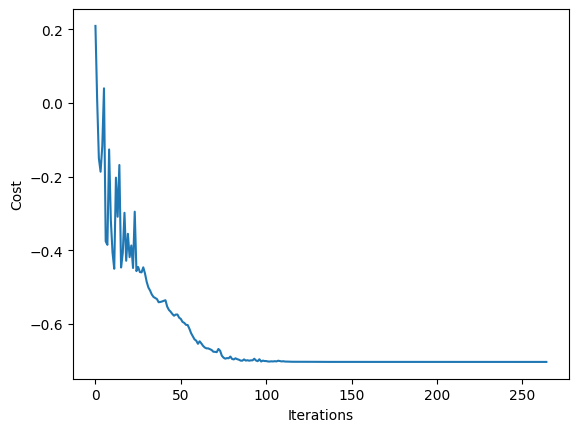

In [39]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()